# Training a convolutional neural network as a one-stage classification model

Importing all required third-party dependencies

In [1]:
import os
import itertools
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

To enforce reproducibility we set the random seed manually

In [2]:
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)

print(f"Used random seed: {torch.initial_seed()}")

Used random seed: 42


We set up the computation device for performing optimization

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"

We will use MNIST dataset of handwritten digits as a supervised classification problem

In [4]:
EPOCHS = 10

BATCH_TRAIN = 512
BATCH_TEST = 512
DATA_DIR = '../../data/'
RESULTS_DIR = '../../results/'

train_dataset = datasets.MNIST(
    root=DATA_DIR, train=True, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

test_dataset = datasets.MNIST(
    root=DATA_DIR, train=False, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_TEST, shuffle=True)

These are examples of handwritten digits from the dataset

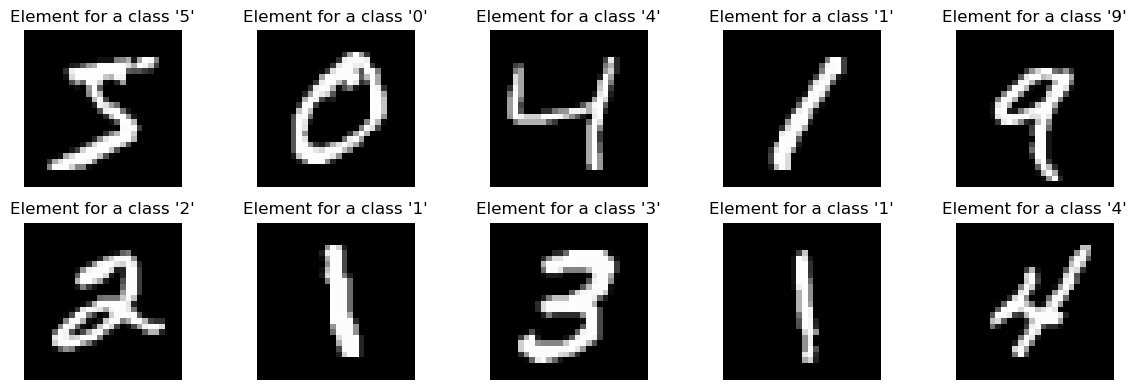

In [5]:
# Selecting random samples for the visual showcase
row_elements = 5

fig, axes = plt.subplots(2, row_elements, figsize=(12, 4))

# Display the samples in the image grid
for i, (image, label) in enumerate(
  itertools.islice(train_dataset, 2 * row_elements)
):
    row = i // row_elements
    col = i % row_elements

    axes[row, col].imshow(image.squeeze(), cmap="gray")
    axes[row, col].set_title(f"Element for a class '{label}'")
    axes[row, col].axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

Each handwritten image can be interpreted as a `(1x28x28)` tensor, where each element is a brightness of a certain pixel

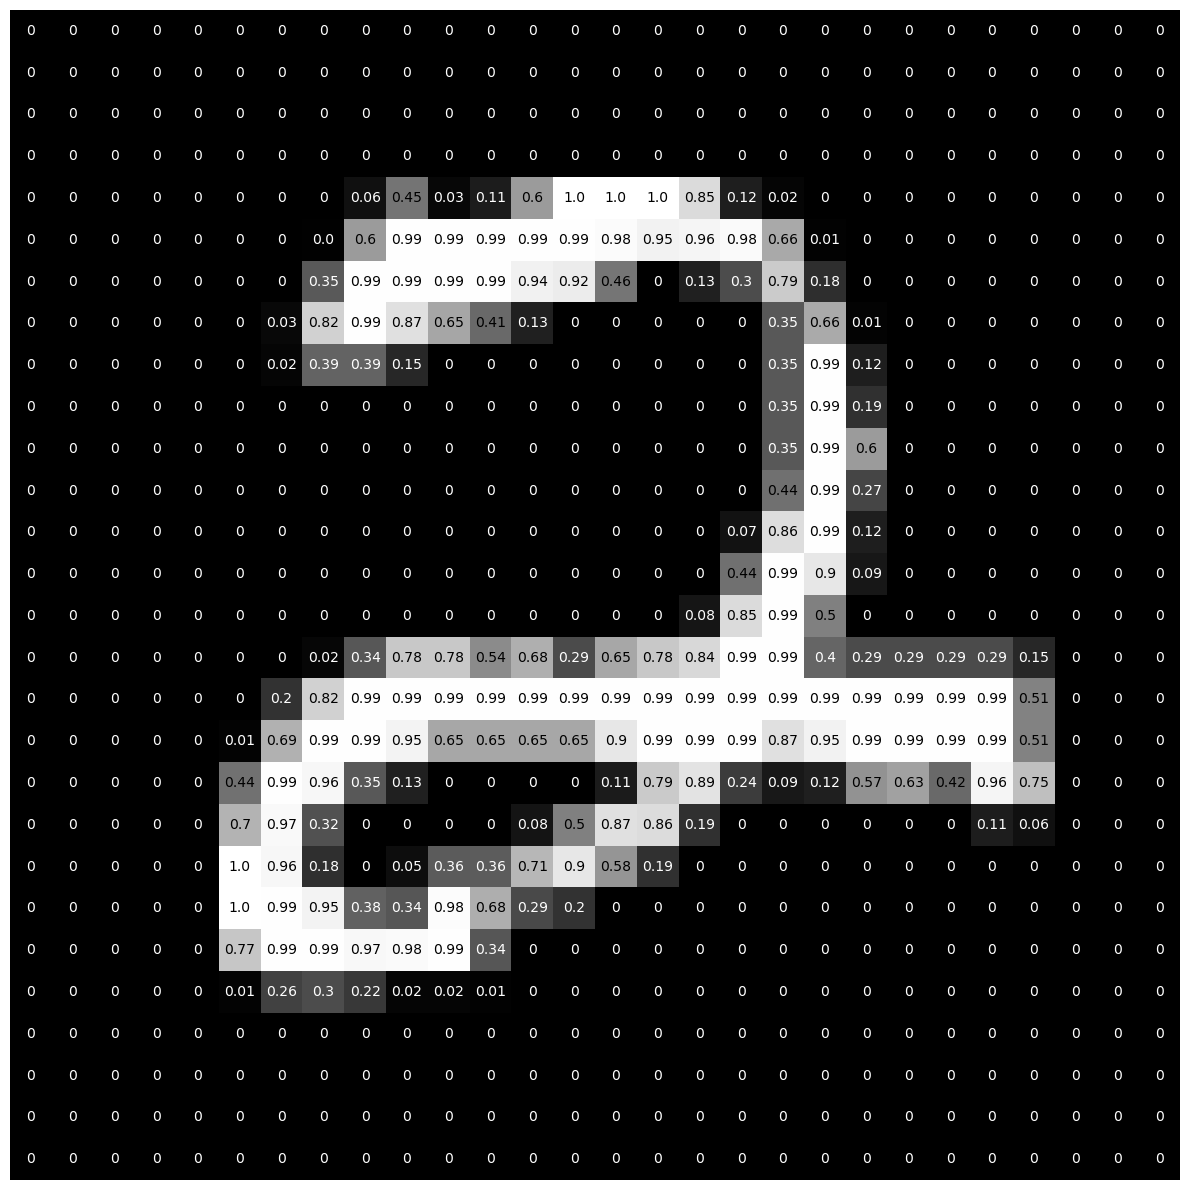

In [6]:
images, labels = next(iter(train_dataloader))
images = images.numpy()
img = np.squeeze(images[1])

fig, ax = plt.subplots(1, 1, figsize=(12, 12)) 
ax.imshow(img, cmap='gray')

width, height = img.shape

for i in range(width):
    for j in range(height):
        val = round(img[i][j], 2) if img[i][j] != 0 else 0
        ax.annotate(str(val), xy=(j, i),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[i][j] < img.max() / 2.5 else 'black')

plt.axis("off")
plt.tight_layout()
plt.show()

A blueprint for a classification convolutional neural network

In [7]:
class ConvClassifier(nn.Module):    
    def __init__(self):
        super(ConvClassifier, self).__init__()

        # Encoder
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Flatten(),

            nn.Linear(64 * 7 * 7, 1000),
            nn.ELU(),

            nn.Linear(1000, 10),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)

Building an instance of a convolutional classification model and training it. We are capturing training and validation loss, as well as accuracy to capture overfitting.

In [8]:
train_loss, train_acc = [], []
val_loss, val_acc = [], []

criterion = nn.CrossEntropyLoss()

cls_model = ConvClassifier().to(device)
optimizer = optim.Adam(cls_model.parameters(), lr=0.001, weight_decay=1e-05)

for epoch in range(EPOCHS):
    epoch_train_loss = []
    epoch_train_acc = []

    epoch_val_loss = []
    epoch_val_acc = []

    total, correct = 0, 0

    # Training loss and accuracy
    cls_model.train()

    for images, labels in (progress_bar := tqdm(train_dataloader)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()

        outputs = cls_model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100.0 * correct / total

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_train_loss.append(loss.item())
        epoch_train_acc.append(accuracy)

        progress_bar.set_description(f"Train loss: {loss.item():.4f}")

    train_loss.append(np.mean(np.array(epoch_train_loss)))
    train_acc.append(np.mean(np.array(epoch_train_acc)))

    # Validation loss and accuracy
    cls_model.eval()

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = cls_model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100.0 * correct / total

            epoch_val_loss.append(loss.item())
            epoch_val_acc.append(accuracy)

    val_loss.append(np.mean(np.array(epoch_val_loss)))
    val_acc.append(np.mean(np.array(epoch_val_acc)))

    print(f"Validation loss: {loss.item():.4f}")

Train loss: 1.5049: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:07<00:00, 15.25it/s]


Validation loss: 1.5117


Train loss: 1.4964: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 29.66it/s]


Validation loss: 1.4813


Train loss: 1.4918: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 29.95it/s]


Validation loss: 1.4830


Train loss: 1.4806: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.04it/s]


Validation loss: 1.4911


Train loss: 1.4790: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 29.96it/s]


Validation loss: 1.4715


Train loss: 1.4909: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 29.85it/s]


Validation loss: 1.4669


Train loss: 1.4719: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:04<00:00, 29.50it/s]


Validation loss: 1.4714


Train loss: 1.4746: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:04<00:00, 29.34it/s]


Validation loss: 1.4707


Train loss: 1.4614: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.09it/s]


Validation loss: 1.4744


Train loss: 1.4728: 100%|█████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 30.15it/s]


Validation loss: 1.4659


We compare train and validation losses to detect the overfitting of the model

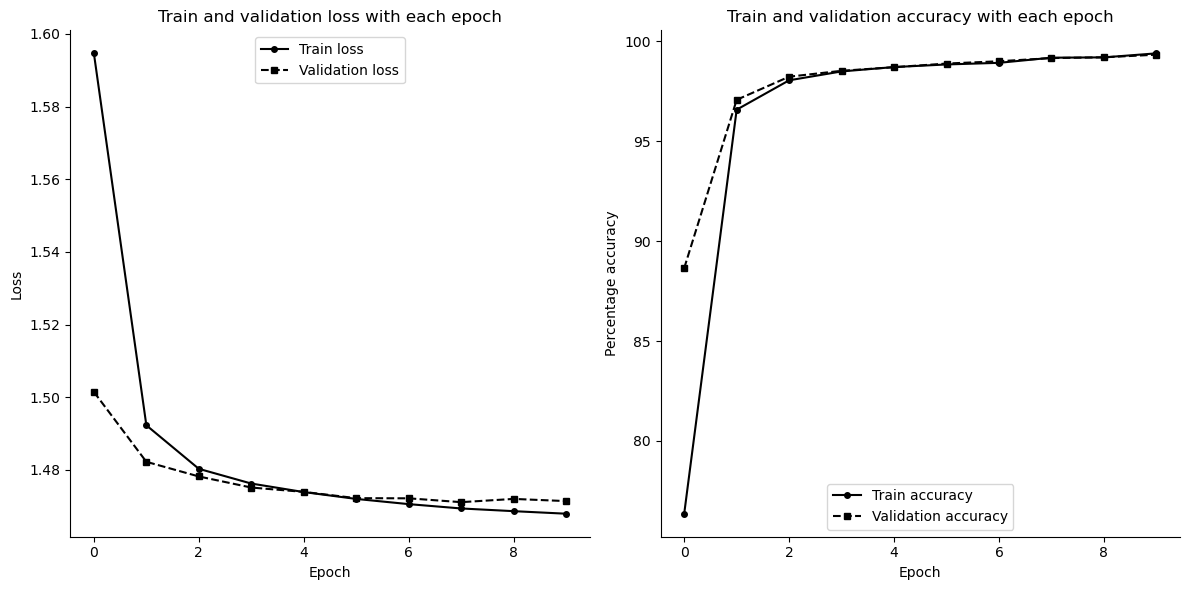

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

ax[0].plot(range(len(train_loss)), train_loss, linestyle='-',
           marker='o', color='k', markersize=4, label="Train loss")
ax[0].plot(range(len(val_loss)), val_loss, linestyle='--',
           marker='s', color='k', markersize=4, label="Validation loss")
ax[0].legend(loc="upper center")
ax[0].set_title("Train and validation loss with each epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[1].plot(range(len(train_acc)), train_acc, linestyle='-',
           marker='o', color='k', markersize=4, label="Train accuracy")
ax[1].plot(range(len(val_acc)), val_acc, linestyle='--',
           marker='s', color='k', markersize=4, label="Validation accuracy")
ax[1].legend(loc="lower center")
ax[1].set_title("Train and validation accuracy with each epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Percentage accuracy")
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

We use confusion matrix to compare the accuracy of classification model for each class

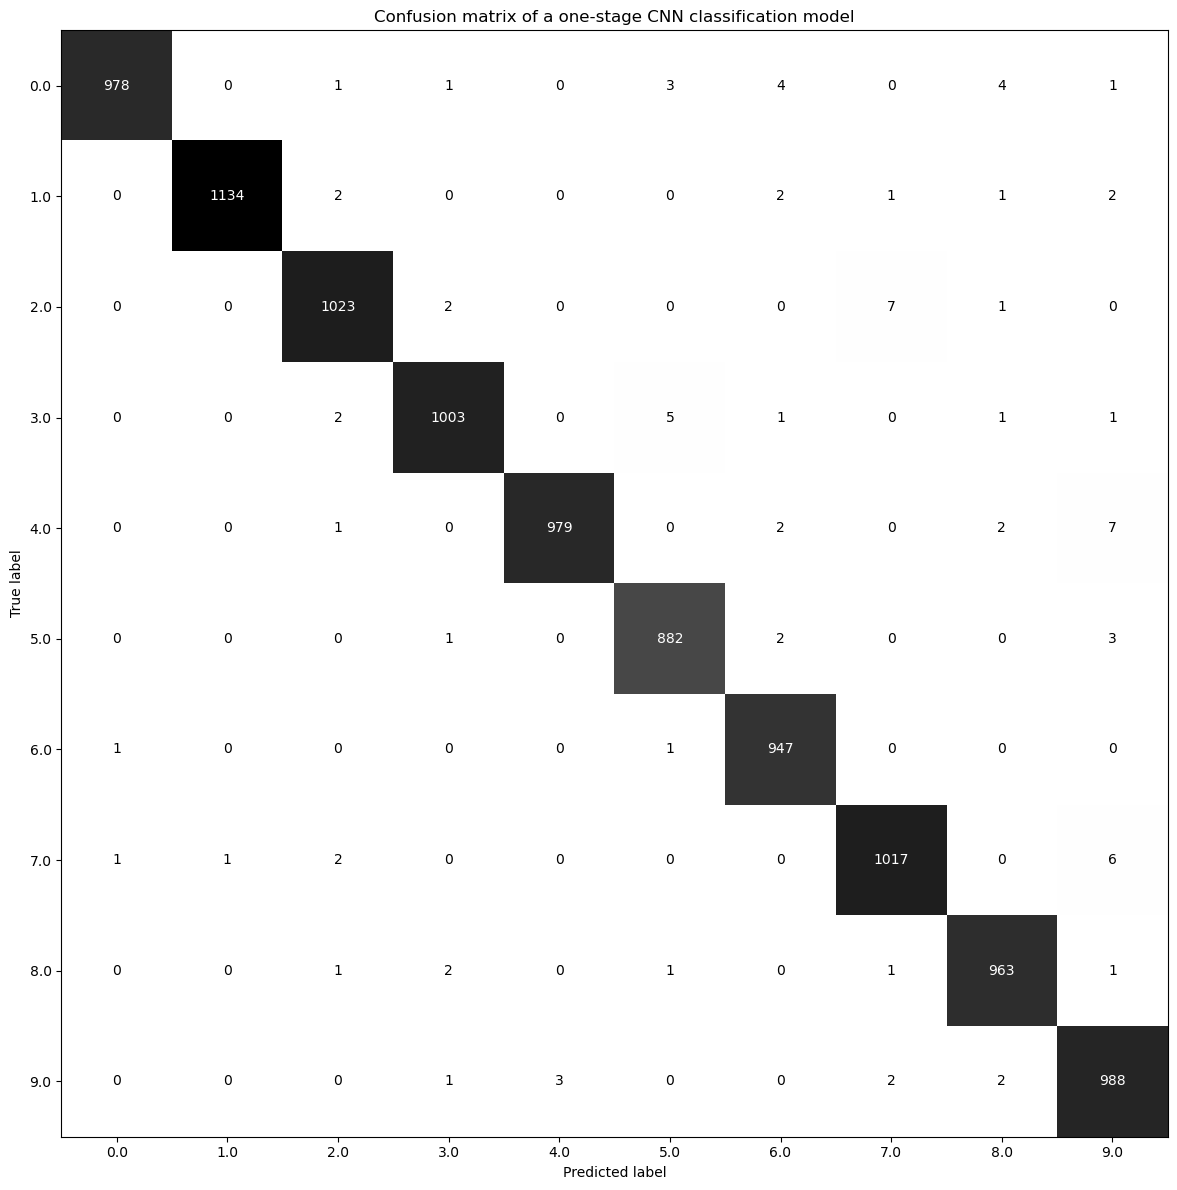

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), tight_layout=True)

cls_model.eval()

y_true = np.array([])
y_pred = np.array([])

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = cls_model(images)
        _, predicted = torch.max(outputs.data, 1)

        y_true = np.append(y_true, predicted.cpu().detach().numpy())
        y_pred = np.append(y_pred, labels.cpu().detach().numpy())

disp = ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, cmap="Greys", colorbar=False, ax=ax
)
ax.set_title("Confusion matrix of a one-stage CNN classification model")

plt.show()

Finally, we compare total accuracy using F1-score metric over all classes

In [11]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9980    0.9859    0.9919       992
         1.0     0.9991    0.9930    0.9960      1142
         2.0     0.9913    0.9903    0.9908      1033
         3.0     0.9931    0.9901    0.9916      1013
         4.0     0.9969    0.9879    0.9924       991
         5.0     0.9888    0.9932    0.9910       888
         6.0     0.9885    0.9979    0.9932       949
         7.0     0.9893    0.9903    0.9898      1027
         8.0     0.9887    0.9938    0.9913       969
         9.0     0.9792    0.9920    0.9855       996

    accuracy                         0.9914     10000
   macro avg     0.9913    0.9914    0.9913     10000
weighted avg     0.9914    0.9914    0.9914     10000



Save classifier model for the later use

In [12]:
MODEL_DIR = os.path.join(RESULTS_DIR, "model")

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

torch.save(cls_model.state_dict(), os.path.join(MODEL_DIR, "cls_model.bin"))